## Parameterize
First thing is to load Curly's spectral simulations and parameterize the disk model. 

In [1]:
## Basic imports for worling with paths
import os
import sys

## Custom package modules
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)


from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import anal_foc_diff_fields as afi
from misloc_mispol_package.optics import diffraction_int as diffi

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import scipy.constants as con
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

import scipy.optimize as opt

eps_b = 1.778
cm_per_nm = 1E-7

In [2]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'sandwiched_nanodisk',
    'simulations'
    )

Need to be fancy with loading the files because matlab v7.3 files require hdf5, whcih is not included in scipy. 

In [3]:
import h5py

AuND_D80_T30_5_6_19_Spectra = {}
f = h5py.File(
    os.path.join(path_to_data, "AuND_D80_T30_5_6_19_Spectra.mat"), 
    'r')

for key, val in f.items():
    AuND_D80_T30_5_6_19_Spectra[key] = np.array(val)[0]

In [4]:
AuND_D80_T30_5_6_19_Spectra.keys()

dict_keys(['f', 'source_intensity', 'source_power', 'transabsorp', 'transscat'])

Text(0.5, 1.0, "Curly's 'Near-Field' spectrum")

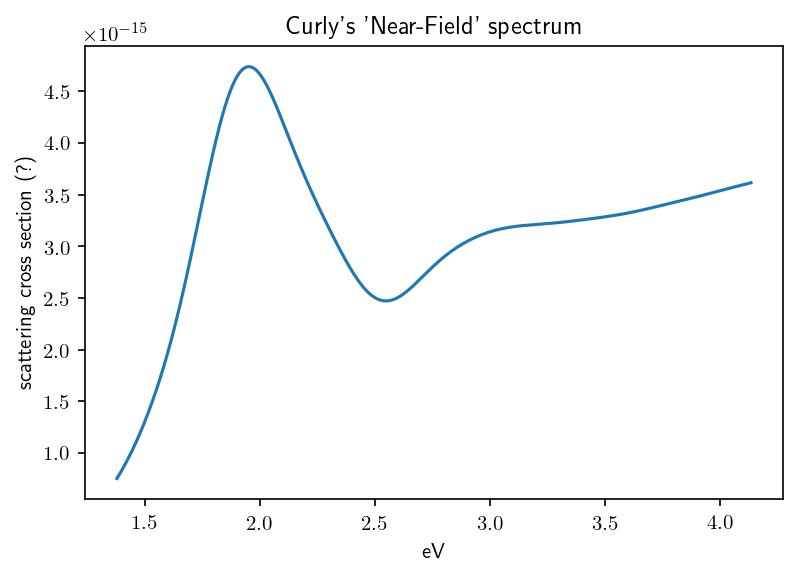

In [5]:
sigma_scat_data = (
    AuND_D80_T30_5_6_19_Spectra['transscat'] 
    * AuND_D80_T30_5_6_19_Spectra['source_power']
    / AuND_D80_T30_5_6_19_Spectra['source_intensity']
    )

hw = hbar * 2 * np.pi * AuND_D80_T30_5_6_19_Spectra['f']

plt.figure(dpi=150)
plt.plot(hw, sigma_scat_data)
plt.xlabel('eV')
plt.ylabel('scattering cross section (?)')
plt.title("Curly's 'Near-Field' spectrum")
# plt.plot(AuND_D80_T30_5_6_19_Spectra['f'], AuND_D80_T30_5_6_19_Spectra['transabsorp'])

In [6]:

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, height, diameter):
    
    a_x = height / 2
    a_yz = diameter / 2
    
    return cp.long_sigma_scat_ret_pro_ellip(
        hbarw/hbar, 
        eps_inf, 
        hbarw_p/hbar, 
        hbargamma/hbar, 
        eps_b, 
        a_x*cm_per_nm, 
        a_yz*cm_per_nm)


In [7]:
#+++++++++++++++++++++++++++++++++++++++++++++
def oblate_cost_func(params, *args):
    x=args[0]
    y=args[1]
    
    ## Parameters
#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a_x = params[3]
#     a_yz = params[4]
    
    y_normed = y/y.max()
    yfit_normed = oblate_fit_result(x, params)

    low_energy_forgiveness = np.ones(x.shape) - (x<1.6) * .1
    return (y_normed-yfit_normed).ravel()*low_energy_forgiveness.ravel()

def oblate_fit_result(x, params):
    
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(x, *phys_params)
    
    return yfit/yfit.max() * amp

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/calc/coupled_dipoles.py:235: RuntimeWarning: invalid value encountered in arctanh
  L = (1-e**2.)/e**3. * (-e + np.arctanh(e))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/calc/coupled_dipoles.py:293: RuntimeWarning: invalid value encountered in arctanh
  D = (a_yz/(2*a_x))*(3/e * np.arctanh(e) - D_x(a_x,a_yz))
/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


array([ 2.08198915,  4.5217819 ,  0.75931619, 22.12505687, 22.12505694,
        0.98936149])

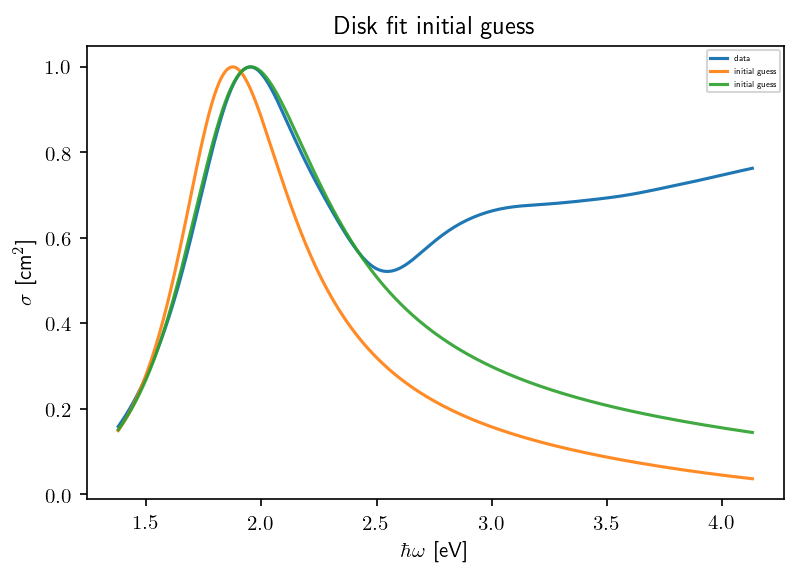

In [8]:
#+++++++++++++++++++++++++++++++++++++++++++++
ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972, .9])
# ini_guess_params=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972, .9])
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 2.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    oblate_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(
#         [0,   0,  0,  20,  60, 0.75],
#         [18, 20, 1,  31,  80, 1.25],
#         ),
    x_scale=[10,10,1E-1,10, 10, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = oblate_fit_result(hw, result['x'])
ini_guess = oblate_fit_result(hw, ini_guess_params)


## Plot
plt.figure(dpi=150)

plt.plot(hw, sigma_scat_data/sigma_scat_data.max(), label='data')
plt.plot(
    hw, 
    ini_guess/ini_guess.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)
plt.plot(
    hw, 
    fit_result/fit_result.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Disk fit initial guess ')
plt.legend(fontsize=4)

result['x']

Actually, it shouldn't be normalized pre-fit since the y-axis should be in $m^2$

In [9]:
#+++++++++++++++++++++++++++++++++++++++++++++
def sph_fit_func(hbarw, eps_inf, hbarw_p, hbargamma, a):
    return cp.sigma_scat_ret_sphere(
        hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a*cm_per_nm)

def sph_cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a = params[3]
#     amp = params[-1]
#     params = params[:-1]
    
    yfit=sph_fit_func(x,*params)
    
    y = y*(1e2**2)*1e10 ## to cm^2 from m^2 (data from BEM)
    yfit = yfit*1e10 ## in cm^2

    return (y-yfit).ravel()

#+++++++++++++++++++++++++++++++++++++++++++++
def absol_oblate_cost_f(params, *args):
    x=args[0]
    y=args[1]
    
    ## Parameters
#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a_x = params[3]
#     a_yz = params[4]
    
    ## Convert data from m^2 to cm^&2
    y = y * (1e2)**2. # cm^2/m^2
    
    ## Define fit function
    yfit = ret_fit_scat_1(x, *params)

    ## Define scale of cost func for rescaling to order unity 
    cost_scale = 1e-10
    
    return (y-yfit).ravel() / cost_scale



array([ 2.28521215,  5.19107343,  0.81912437, 36.65026517])

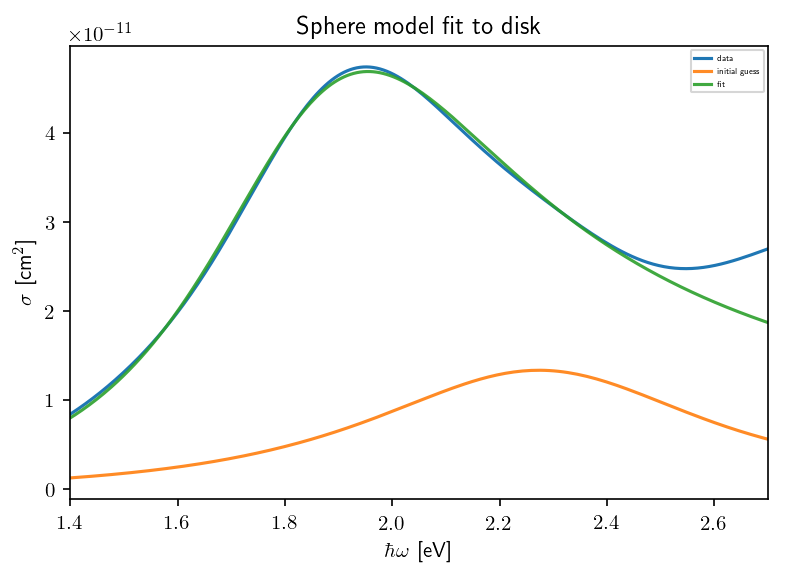

In [10]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, ])#80.24119972,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 2.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    sph_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(
#         [0,   0,  0,  20,  60, 0.75],
#         [18, 20, 1,  31,  80, 1.25],
#         ),
    x_scale=[10,10,1E-1,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = sph_fit_func(hw, *result['x'])
ini_guess = sph_fit_func(hw, *ini_guess_params)


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E4, label='data')

## Plot initial guess
plt.plot(
    hw, 
    ini_guess, 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

plt.xlabel(r'$\hbar\omega$ [eV]')
plt.xlim([1.4, 2.7])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Sphere model fit to disk')
plt.legend(fontsize=4)

result['x']

array([ 2.55953044,  6.35014725,  0.84830418, 40.        , 82.72501486])

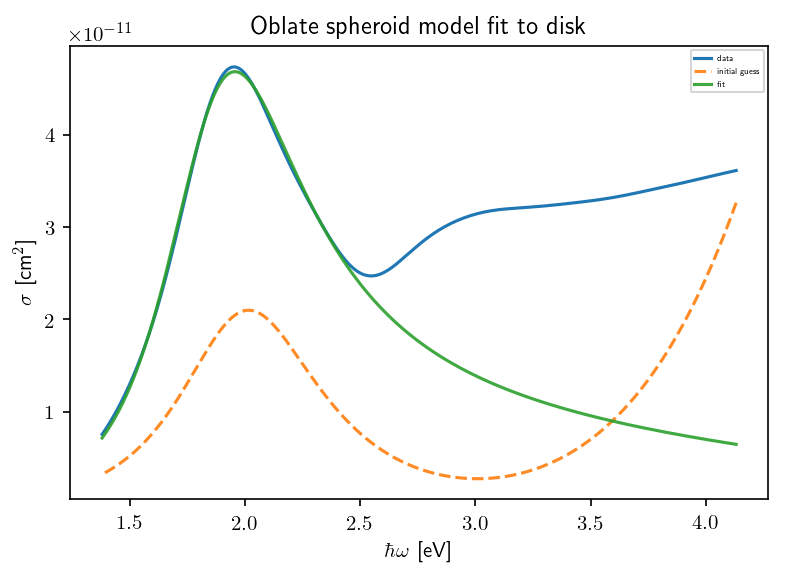

In [11]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 2.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    absol_oblate_cost_f, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [0,   0,  0,  30, 70],
        [18, 20, 1,  40, 90],
        ),
    x_scale=[10,10,1E-1,10, 10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params)


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E4, label='data')

## Plot initial guess
plt.plot(
    hw, 
    ini_guess, 
    label='initial guess',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to disk')
plt.legend(fontsize=4)

result['x']

#### Try fitting with a high energy Gaussian 
Because I think its more right then not. 

In [12]:


#+++++++++++++++++++++++++++++++++++++++++++++

def hiengau_cost_func(params, *args):
    x=args[0]
    y=args[1]
    
    ## Parameteres;
    ##     eps_inf=params[0]
    ##     w_p=params[1]
    ##     gamma=params[2]
    ##     a = params[3]
    ##
    ## Gaussian parameters
    gau_amp = params[-3]
    mu = params[-2]
    std_dev = params[-1]
    
    high_en_gau = gau_amp*np.exp(-(x-mu)**2./std_dev**2.)*1E-10
    
    ## Add Gaussian and model 
    yfit = (
        ret_fit_scat_1(x,*params[:-3]) 
        + 
        high_en_gau
        )
    
    ## Convert data to theoretical units
    y = y*(1e2**2) ## to cm^2 from m^2 (data from BEM)
    
    cost_scale = 1e-10

    return (y-yfit).ravel()/cost_scale

array([ 4.13099032,  6.97497861,  0.84471359, 40.        , 84.99522714,
        0.21344456,  3.02796414,  0.41488853])

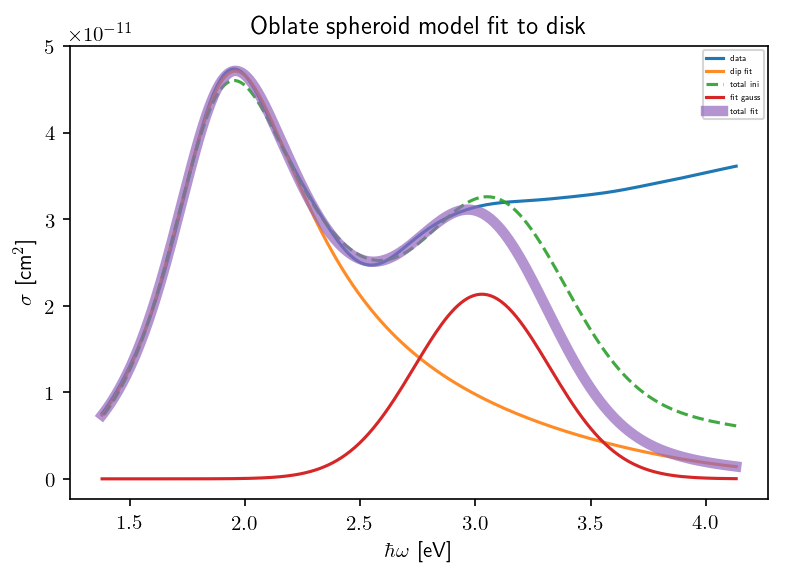

In [13]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([2.8,  7.00751248,  0.85788033, 31.        , 85.69362266,
    ## Gaussian Parameters
    .2,
    3.1,
    0.42,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 3.
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    hiengau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, 70, .01,  2.75, 0],
        [18, 20,     1,  40, 90,  .5,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, 10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E4, label='data')

## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='--', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
# plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to disk')
plt.legend(fontsize=4)

result['x']

array([ 6.89392999,  8.44951725,  0.83493485, 30.        , 89.83161222,
        0.27852103,  3.17445476,  0.59509663])

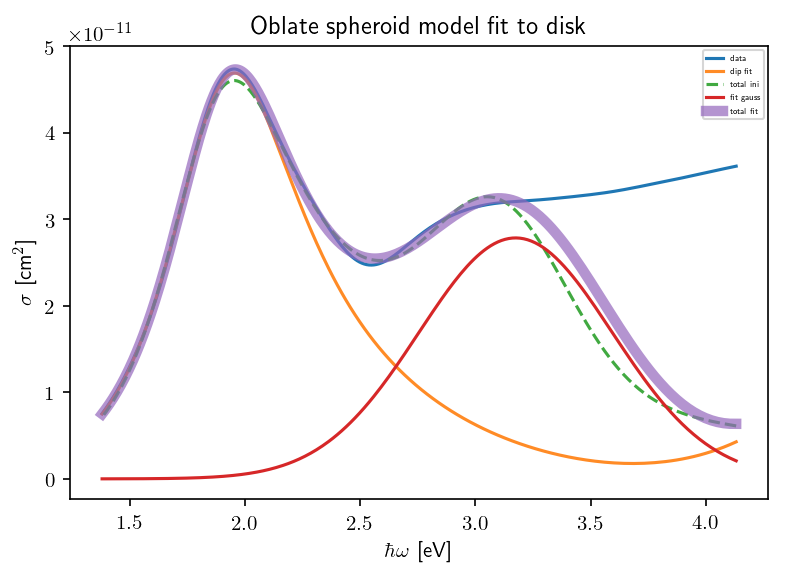

In [14]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([2.8,  7.00751248,  0.85788033, 31.        , 85.69362266,
    ## Gaussian Parameters
    .2,
    3.1,
    0.42,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 3.25
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    hiengau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, 70, .01,  2.75, 0],
        [18, 20,     1,  41, 90,  .5,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, 10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E4, label='data')

# ## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='--', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
# plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to disk')
plt.legend(fontsize=4)

result['x']

array([10.25632268,  8.95050193,  0.80321284, 36.93759793, 90.        ,
        0.27810055,  3.12451485,  0.70000847])

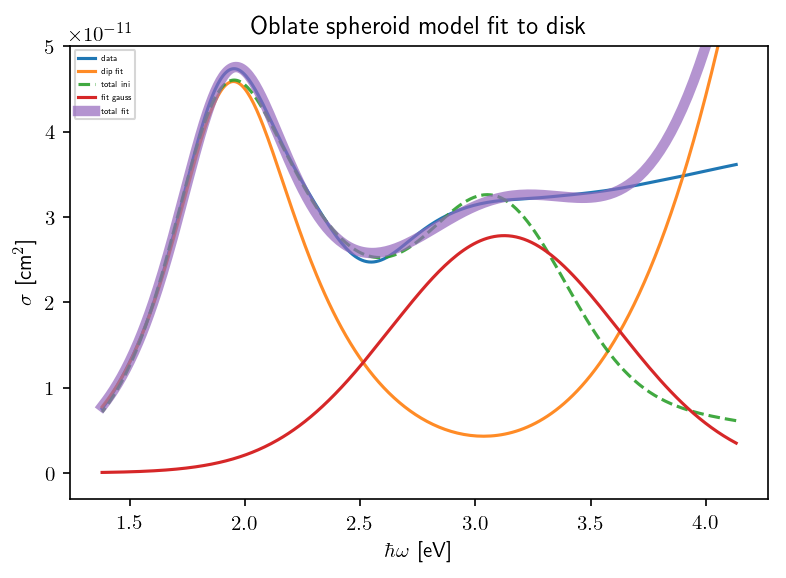

In [15]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([2.8,  7.00751248,  0.85788033, 31.        , 85.69362266,
    ## Gaussian Parameters
    .2,
    3.1,
    0.42,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 3.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    hiengau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, 70, .01,  2.75, 0],
        [18, 20,     1,  40, 90,  .5,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, 10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E4, label='data')

# ## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='--', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
# plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to disk')
plt.legend(fontsize=4)

result['x']

 active_mask: array([0, 0, 0, 1, 1, 0, 0, 0])
        cost: 0.0037977709677327904
         fun: array([ 3.55958432e-03,  4.14153896e-03,  4.38379615e-03,  4.34382982e-03,
        4.07518219e-03,  3.62645658e-03,  3.04062474e-03,  2.35472064e-03,
        1.59993488e-03,  8.02071453e-04, -1.77116106e-05, -8.41982490e-04,
       -1.65605144e-03, -2.44703234e-03, -3.20304313e-03, -3.91261308e-03,
       -4.56433458e-03, -5.14676682e-03, -5.64857054e-03, -6.05883081e-03,
       -6.36750913e-03, -6.56595846e-03, -6.64743452e-03, -6.60754338e-03,
       -6.44457654e-03, -6.15970027e-03, -5.75698226e-03, -5.24325539e-03,
       -4.62783327e-03, -3.92210439e-03, -3.13904006e-03, -2.29265640e-03,
       -1.39747100e-03, -4.67992331e-04,  4.81725428e-04,  1.43843777e-03,
        2.38995962e-03,  3.32530345e-03,  4.23470882e-03,  5.10957451e-03,
        5.94231104e-03,  6.72613609e-03,  7.45483803e-03,  8.12253337e-03,
        8.72344266e-03,  9.25170645e-03,  9.70125881e-03,  1.00657705e-02,
    

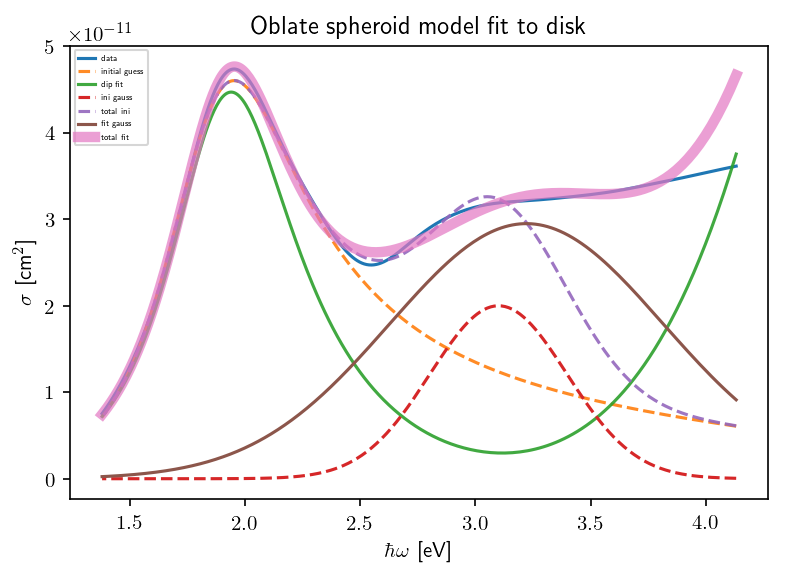

In [16]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([2.8,  7.00751248,  0.85788033, 31.        , 85.69362266,
    ## Gaussian Parameters
    .2,
    3.1,
    0.42,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 3.75
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    hiengau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [1,   1,  0.01,  30, 70, .01,  2.75, 0],
        [18, 20,     1,  31, 90,  .5,     4, 1],
        ),
    x_scale=[1,1,1E-1,10, 10, .01, 1, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'][:-3])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params[:-3])


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E4, label='data')

## Plot initial guess
plt.plot(
    hw, 
    ini_guess, 
    label='initial guess',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='dip fit',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot Gaussian initial guess 
ini_gaus = (
    ini_guess_params[-3]*1e-10
    *
    np.exp(
        -(ini_guess_params[-2]-hw)**2.
        /
        ini_guess_params[-1]**2.
        )
    )
plt.plot(hw, ini_gaus, ls='--', label='ini gauss')

## Plot total initial guess
plt.plot(
    hw, 
    ini_gaus + ini_guess, 
    label='total ini',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)



## Plot Gaussian fit
fit_gauss = (
    result['x'][-3]*1e-10
    *
    np.exp(
        -(result['x'][-2]-hw)**2.
        /
        result['x'][-1]**2.
        )
    )
plt.plot(hw, fit_gauss, label='fit gauss')

## Plot total fit result
total_fit = fit_gauss + fit_result
plt.plot(
    hw, 
    total_fit, 
    label='total fit',
#     ls=' ', 
#     marker='.', 
#     markersize=1, 
    lw=5,
    alpha=.7)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylim([None, .5e-10])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to disk')
plt.legend(fontsize=4)

result

## Plan

- parameterize plasmon
    - ...
- parameterize molecule
    - will have to think about this one. Fitting Curly's simulation, but how does the molecule act in the sims? I am not sure if it is flat is frequency space like in BEM. Maybe it doesnt matter too much if I pick a single frequency. 
- fit images 